# Working with MNE and EEG-BIDS Part 2

In this notebook we will go over:


*   Epochs and evoked responses
*   Cleaning epoched data



# Import packages

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs)

Ensure Matplotlib uses the `Qt5Agg` backend, which is the best choice for MNE-Python's interactive plotting functions. 

In [32]:
#matplotlib.use('Qt5Agg')

For some system you might want to use  `%matplotlib qt`

In [33]:
%matplotlib qt

# Load Dataset

We will continue to work on the BIDS version of our sample dataset created in the previous notebook.

In [34]:
#Set the path to the location of the BIDS data
bids_root = pathlib.Path('out_data/sample_BIDS')
#Set the variables for the BIDS directory
bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='audiovisual',
                              run='01',
                              datatype='meg',
                              root=bids_root)
#Read and load the data
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
raw.filter(l_freq=1, h_freq=40)
events, event_id = mne.events_from_annotations(raw)

Opening raw data file out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_meg.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 85861 =     42.956 ...   142.955 secs
Ready.
Reading events from out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_events.tsv.
Reading channel info from out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_channels.tsv.
Reading 0 ... 60061  =      0.000 ...    99.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.3s


Used Annotations descriptions: ['Auditory/Left', 'Auditory/Right', 'Button', 'Smiley', 'Visual/Left', 'Visual/Right']


# Creating epochs and generating evoked responses (ERP/ERF)

Evoked objects typically store EEG signals that have been averaged over multiple epochs, which is a common technique for estimating stimulus-evoked activity. Thus, to create an Evoked object, we’ll start by epoching some raw data, and then averaging together all the epochs from one condition.

## Create epochs for the events

In [35]:
#Epochs will start 300 ms before the stimulus onset and end 
#500 ms after stimulus onset
tmin = -0.3
tmax = 0.5
baseline = (None, 0)

epochs = mne.Epochs(raw,
                    events=events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True)
epochs

Not setting metadata
147 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 147 events and 481 original time points ...
1 bad epochs dropped


Number of events,146
Events,Auditory/Left: 34Auditory/Right: 34Button: 7Smiley: 7Visual/Left: 33Visual/Right: 31
Time range,-0.300 – 0.499 s
Baseline,-0.300 – 0.000 s


In [36]:
epochs.plot(picks = ['eeg']);

We can look at epochs based on condition

In [37]:
epochs['Auditory/Right']

Number of events,34
Events,Auditory/Right: 34
Time range,-0.300 – 0.499 s
Baseline,-0.300 – 0.000 s


In [38]:
epochs['Auditory']

Number of events,68
Events,Auditory/Left: 34Auditory/Right: 34
Time range,-0.300 – 0.499 s
Baseline,-0.300 – 0.000 s


In [39]:
epochs['Left']

Number of events,67
Events,Auditory/Left: 34Visual/Left: 33
Time range,-0.300 – 0.499 s
Baseline,-0.300 – 0.000 s


Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


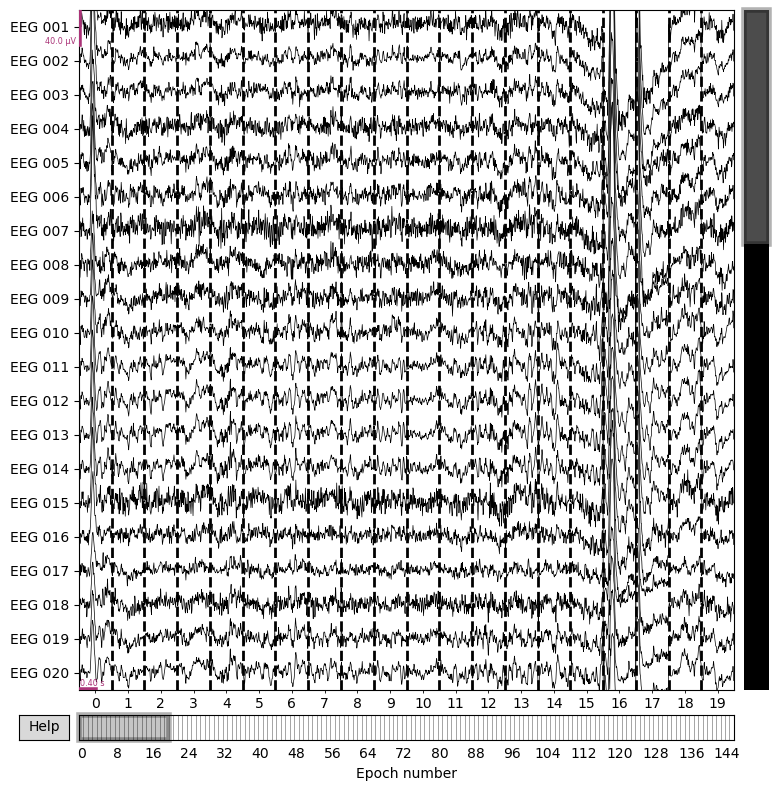

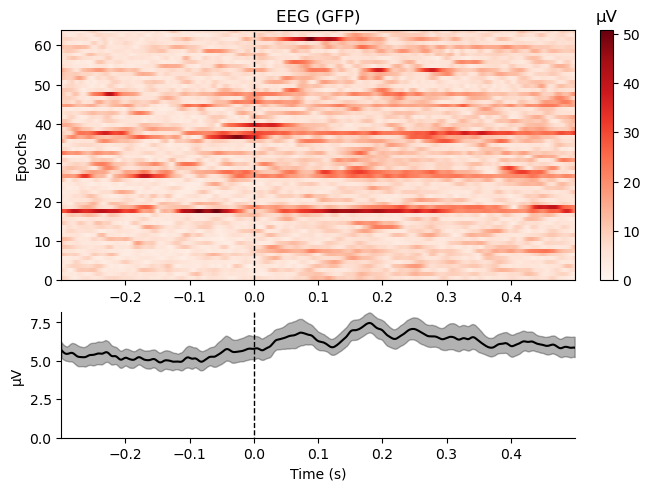

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['MEG 2443', 'EEG 051', 'EEG 053']


[<Figure size 640x480 with 3 Axes>]

In [40]:
%matplotlib inline
epochs['Visual'].plot_image(picks = "eeg")

### Saving epochs

In [41]:
epochs.save(pathlib.Path('out_data') / 'epochs_epo.fif', 
            overwrite=True)

Overwriting existing file.
Overwriting existing file.


## Creating evoked data

Now we can create evoked responses for each condition

In [42]:
evoked_auditory = epochs['Auditory'].average()
evoked_visual = epochs['Visual'].average()

## Basic visualization of Evoked objects
We can visualize the average evoked response for the auditory stimuli using the plot() method, which yields a butterfly plot of each channel type. Like many MNE-Python plotting functions, evoked.plot() has a picks parameter that can select channels to plot by name, index, or type. We will specifically look at EEG channels.

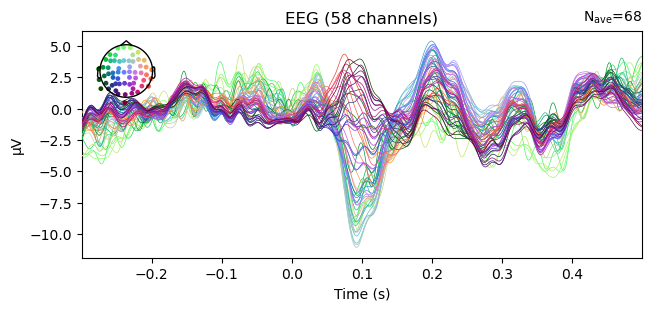

In [43]:
evoked_auditory.plot(spatial_colors=True, picks = ['eeg']);

In an interactive session, the butterfly plots seen above can be click-dragged to select a time region, which will pop up a map of the average field distribution over the scalp for the selected time span. You can also generate scalp topographies seperately or jointly at specific times or time spans using the plot_topomap() method.

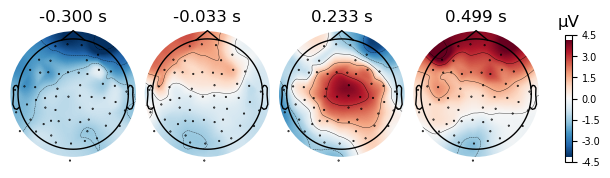

In [44]:
evoked_auditory.plot_topomap(ch_type='eeg');

Joint plots combine butterfly plots with scalp topographies, and provide an excellent first-look at evoked data; by default, topographies will be automatically placed based on peak finding. 

Projections have already been applied. Setting proj attribute to True.


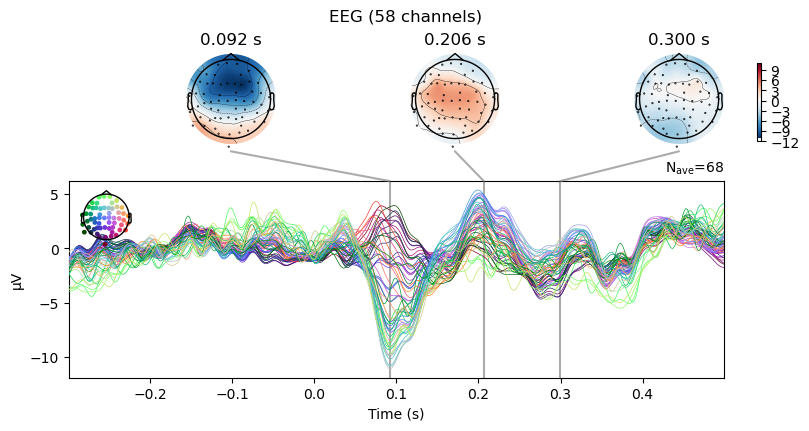

In [45]:
evoked_auditory.plot_joint(picks='eeg');

Here we compare evoked responses by looking at the global field power (an average-referenced RMS)

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


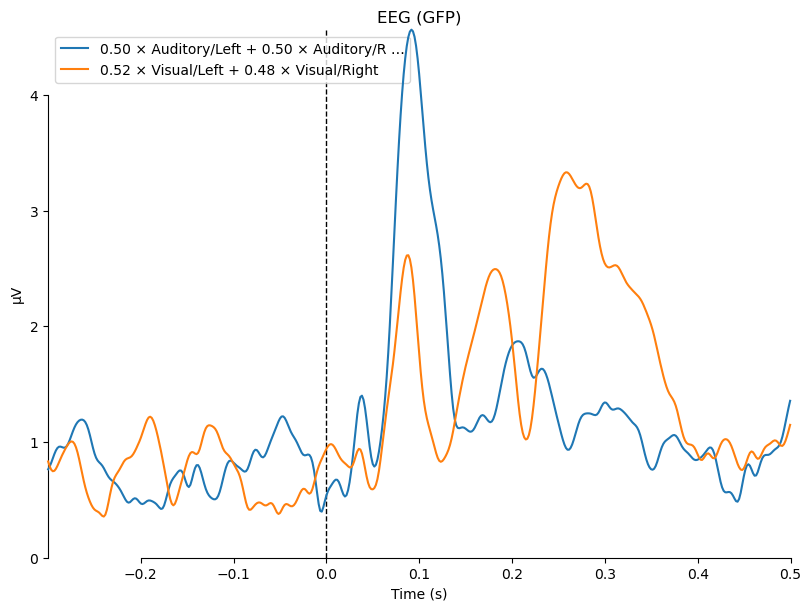

In [46]:
mne.viz.plot_compare_evokeds([evoked_auditory, evoked_visual], picks='eeg');

## Saving evoked data

In [47]:
mne.write_evokeds(fname=pathlib.Path('out_data') / 'evokeds_ave.fif',
                  evoked=[evoked_auditory, evoked_visual],overwrite=True)

Overwriting existing file.


# Cleaning the Data

Severe contamination of EEG activity by eye movements, blinks, muscle, heart and line noise is a serious problem for EEG interpretation and analysis. One method proposed to remove a wide variety of artifacts from EEG recordings is **Independent Component Analysis (ICA)**.

## ICA Artifact Detection and Removal


Independent components analysis (ICA) is a technique for estimating independent source signals from a set of recordings in which the source signals were mixed together in unknown ratios. 

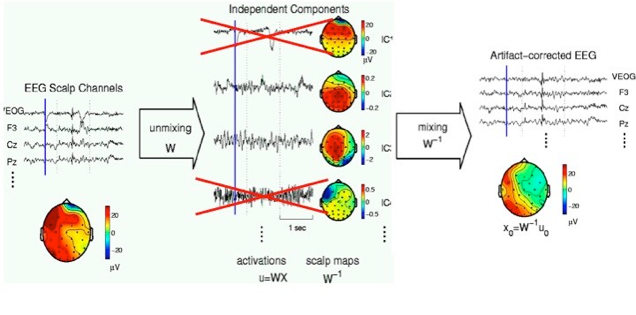


We will apply ICA on our epoched data but this can be done directly on the filtered raw data as well.

In [48]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')

Reading /home/yhashim/Documents/Research/University of Toronto/Week 2/mne_eeg_workshop/out_data/epochs_epo.fif ...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
    Found the data of interest:
        t =    -299.69 ...     499.49 ms
        0 CTF compensation matrices available
Not setting metadata
146 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
3 projection items activated


In [49]:
#we will work the eeg channels only
epochs.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Number of events,146
Events,Auditory/Left: 34Auditory/Right: 34Button: 7Smiley: 7Visual/Left: 33Visual/Right: 31
Time range,-0.300 – 0.499 s
Baseline,-0.300 – 0.000 s


### Fitting and plotting the ICA solution

In [50]:
n_components = 20
method = 'infomax'
max_iter = 100  # Should normally be higher, like 500 or even 1000!!
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            random_state=random_state)
ica.fit(epochs)

Fitting ICA to data using 58 channels (please be patient, this may take a while)


/tmp/ipykernel_79406/27885579.py:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 20 components
Computing Infomax ICA
Fitting ICA took 7.3s.


Method,infomax
Fit parameters,extended=Falsemax_iter=100
Fit,100 iterations on epochs (70226 samples)
ICA components,20
Available PCA components,58
Channel types,eeg
ICA components marked for exclusion,—


note if you need to rerun ICA you need to delete the ica instance saved in memory ``` del ica ```

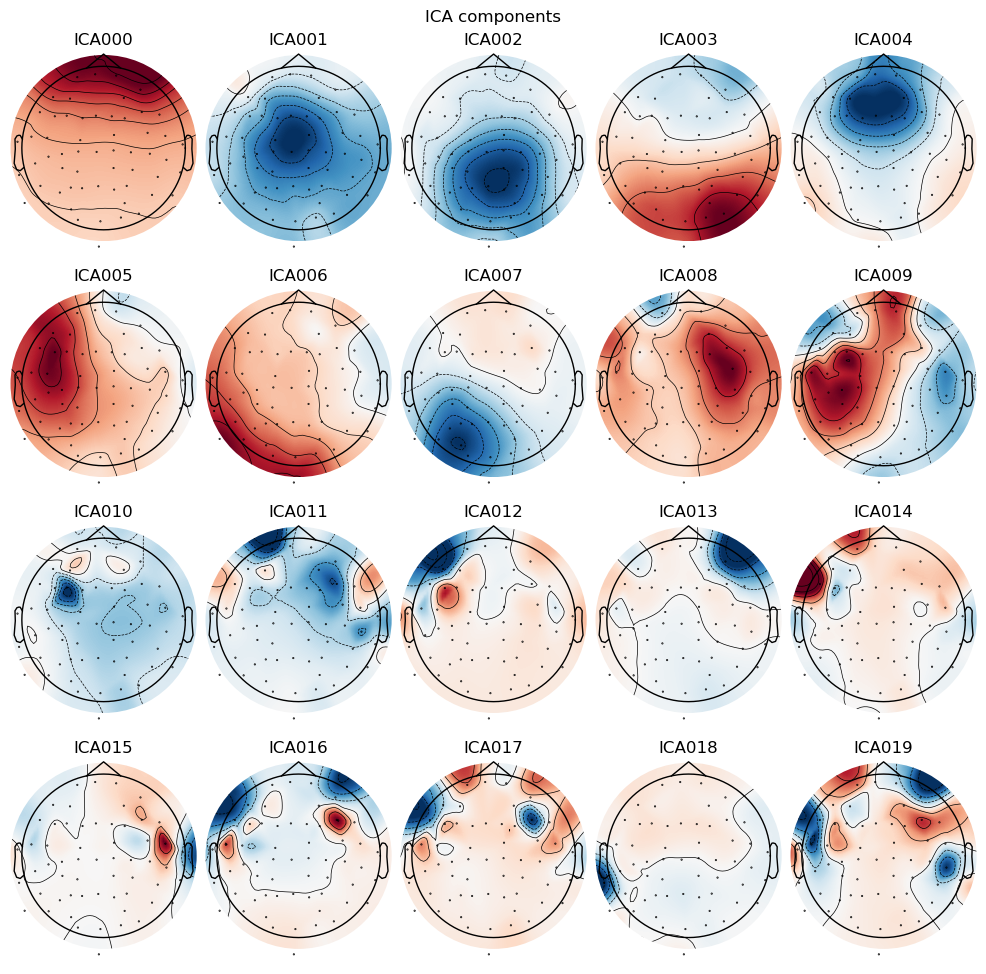

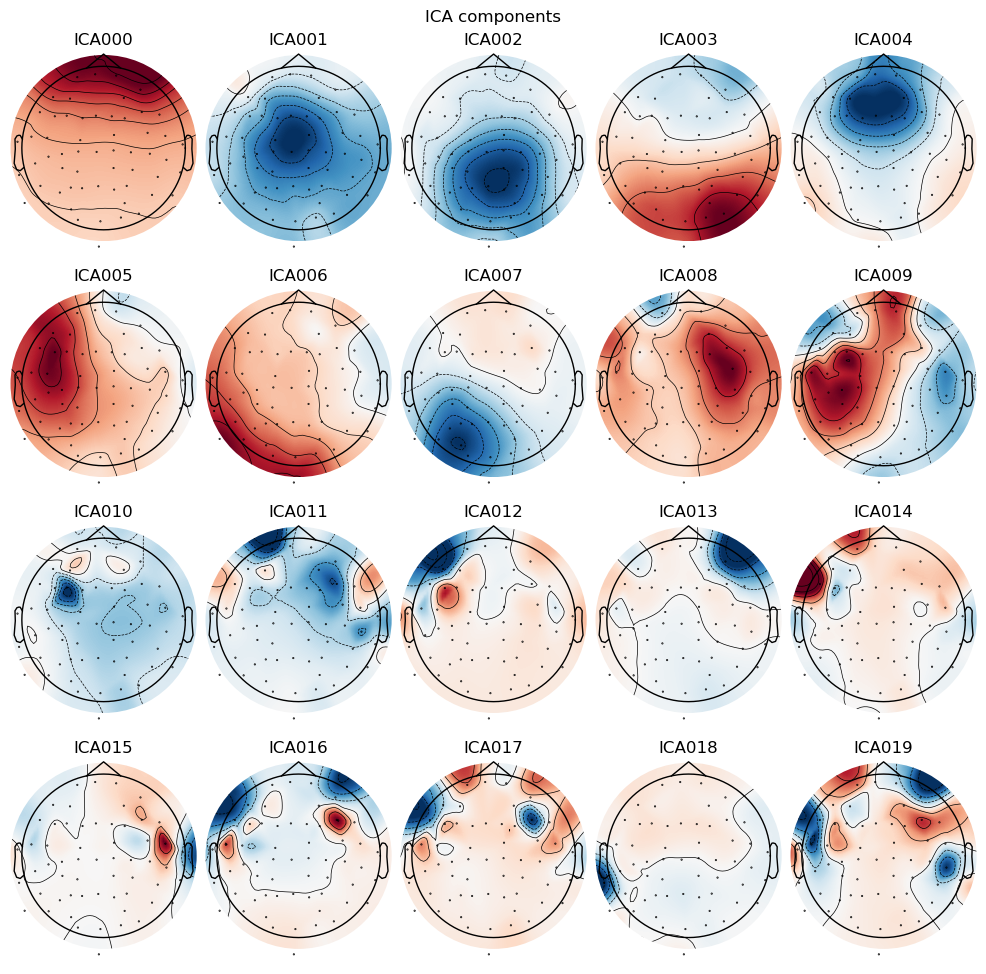

In [51]:
ica.plot_components(inst=epochs)

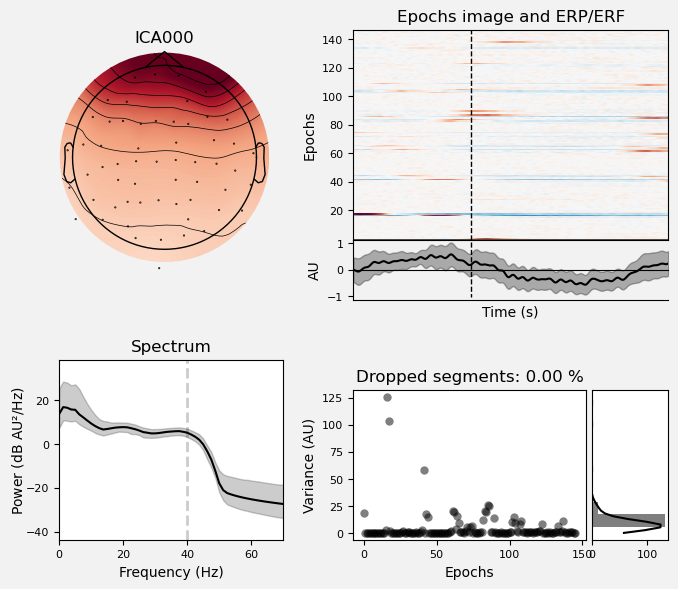

[<Figure size 700x600 with 6 Axes>]

In [52]:
ica.plot_properties(epochs,picks =[0],psd_args ={'fmax': 70}, verbose='WARNING')

In [53]:
%matplotlib qt
ica.plot_sources(epochs,show_scrollbars=False);

Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated


### Selecting ICA Components Manually

For more info on visually identifying Independent Components, this [EEGLAB guide](https://labeling.ucsd.edu/tutorial/labels) is a good resource.

Let's say we decided to remove the first component, we can plot and see what the signal looks like before and after exclusion using an overlay plot.

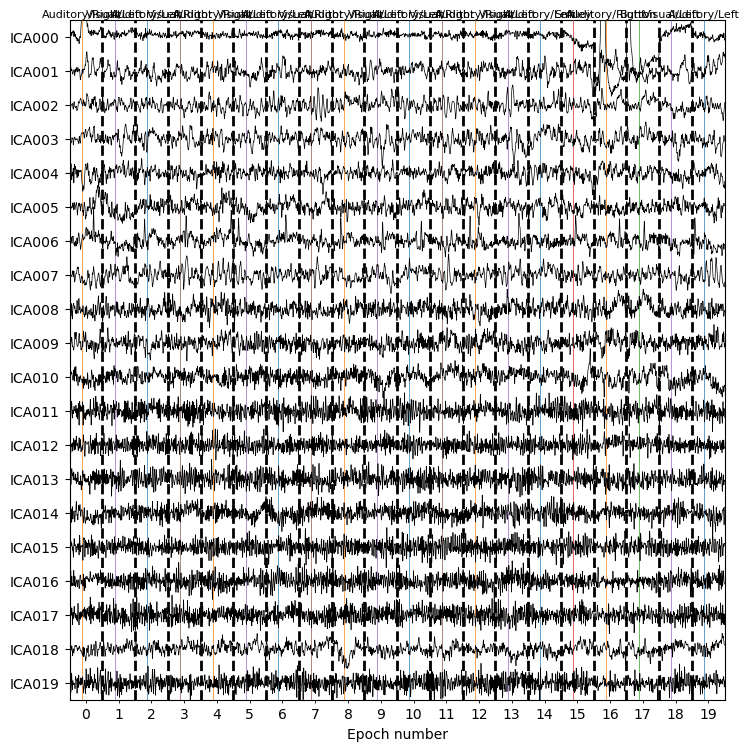

In [ ]:
%matplotlib inline
ica.plot_overlay(raw, exclude=[0], verbose='WARNING');

Now we apply the exclusion

In [ ]:
ica.exclude = [0] 
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_epochs = epochs.copy()
ica.apply(reconst_epochs)

We can plot and compare before and after ICA

In [ ]:
%matplotlib qt
epochs.plot();
reconst_epochs.plot();

### Automatic: Using an EOG/ECG channel to select ICA components

It may have seemed easy to review the plots and manually select which ICs to exclude, but when processing dozens or hundreds of subjects this can become a tedious, rate-limiting step in the analysis pipeline. One alternative is to use dedicated EOG or ECG sensors as a “pattern” to check the ICs against, and automatically mark for exclusion any ICs that match the EOG/ECG pattern.

We apply this to the raw data

#### EOG

In [ ]:
%matplotlib inline
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint();

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores);

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices);

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw);

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked, picks=0);

#### ECG

In [ ]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint();

In [ ]:
ica.exclude = []
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw)
ica.exclude = ecg_indices

# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked);

# Refrences

**MNE-Python** - 
Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.


### Exercise #2

1) Read the file 'sub-s01_task-faceFO_eeg.fif' as an epoched object

2) Make a joint plot of the time-series? 

3) Create a variable with the array of the evoked data

4) Decompose the data using SVD (use the function  `numpy.linalg.svd`)


5) Make a `matplotlib` figure with 1 row and 5 columns and plot the first 5 components using the function `mne.viz.plot_topomap`